In [14]:
import pickle 
import dgl 
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib as mpl
from matplotlib.pyplot import cm


mpl.rcParams['font.size'] = 30
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Tahoma']

In [15]:
def plot_bg(embs, bg_alpha=.02, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    
    emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def plot_with_annotations(embs, label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(embs, **kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='red')
    return ax


def plot_artist(embs, df_items, artists, alpha=1, **kwargs): 
    ax = plot_bg(embs, **kwargs)
    for a,t in artists.items(): 
        name, color=t
        tracks = df_items[df_items.artist_name == a].tid
        Xlabeled = embs[tracks, 0]
        Ylabeled = embs[tracks, 1]
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color=color, label=name)
    ax.legend()
    return ax 

def plot_by_genre(embs, df_items, artists, alpha=1, **kwargs): 
    ax = plot_bg(embs, **kwargs)
    for a,c in artists.items(): 
        name, color=a, c
        tracks = df_items[df_items.artist_name == a].tid
        Xlabeled = embs[tracks, 0]
        Ylabeled = embs[tracks, 1]
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color=color, label=name)
    ax.legend()
    return ax 

        
def plot_counterfactuals(embs, og_idx, cf_idx, name, alpha=1, centroid = True, lines = True, annotate=False, legend=False, **kwargs): 
    ax = plot_bg(embs, **kwargs)
    X_og = embs[og_idx, 0]
    Y_og = embs[og_idx, 1]
    
    ax.scatter(X_og, Y_og, alpha=0.7, color='red', label='original', s=20)
    X_cf = embs[cf_idx, 0]
    Y_cf = embs[cf_idx, 1]
    ax.scatter(X_cf, Y_cf, alpha=0.7, color='blue', label='counterfactual', s=20)
    if legend: 
        ax.legend(loc='upper left', fontsize=30)
    dist = None 
    if centroid: 
        og_centroid = [np.mean(X_og), np.mean(Y_og)]
        cf_centroid = [np.mean(X_cf), np.mean(Y_cf)]
        ax.scatter(og_centroid[0], og_centroid[1], alpha=alpha, color='red', marker = 'o', s=300)
        ax.scatter(cf_centroid[0], cf_centroid[1], alpha=alpha, color='blue', marker = 'o', s=300)
        dist = np.linalg.norm(np.array(og_centroid)- np.array(cf_centroid))
        dist_round = np.round(dist, 3)
        print(dist_round)
        if lines: 
            for i in range(len(X_cf)):
                x = [X_cf[i], cf_centroid[0]]
                y = [Y_cf[i], cf_centroid[1]]
                ax.plot(x, y, c='blue', alpha=0.2, label='counterfactual centroid')
            
            for i in range(len(X_cf)):
                x = [X_og[i], og_centroid[0]]
                y = [Y_og[i], og_centroid[1]]
                ax.plot(x, y, c='red', alpha=0.2, label='original centroid')
        if annotate: 

            plt.annotate(
               f'centroid distance:{dist_round}',
               xy=(og_centroid[0], og_centroid[1]), xytext=(-20, +200),
               textcoords='offset points', ha='center', va='bottom',
               bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.5), fontsize=15)
        
        ax.set_title(f"{name}: Distance:{dist_round:.3f}", fontsize=40)
    return ax, dist
    

In [16]:
def load_all(data, u_emb, flag=False ):
    data = pickle.load(open(data, "rb"))
    if flag: 
        data = data['df_track']
        emb = pickle.load(open(u_emb, "rb"))
    else: 
        emb = pickle.load(open(u_emb, "rb")).detach().numpy()
    
    return data, emb 
    
def PCA_on_emb(emb): 
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    u_pca = pca.fit_transform(emb) 

    u_df = pd.DataFrame()
    u_df['x'] = u_pca[:, 0]
    u_df['y'] = u_pca[:, 1]

    return u_pca, u_df

def find_CF(df_items): 
    cf = df_items[df_items.track_name.str.contains('_CF')]
    cf_tid = cf.tid.tolist() 
    
    og = df_items[(df_items.track_uri.isin(cf.track_uri.tolist())) & ~(df_items.tid.isin(cf_tid))]
    og_tid = og.tid.tolist() 
    return cf_tid, og_tid 

In [17]:
NGCF_data_path = '/home/mila/r/rebecca.salganik/scratch/MusicSAGE_Data/datasets/small_100_10/train_val3.pkl'
NGCF_emb_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/OLD/benchmarks/NGCF/small_cf_track_emb.pkl'


REDRESS_data_path = '/home/mila/r/rebecca.salganik/scratch/MusicSAGE_Data/datasets/small_100_10/train_val3.pkl'
# scratch = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/OLD/ablations_small_100_10/fairness_hp/cf/_G_1.0_A_0.01_B_0.0_Batch_1000/'
# REDRESS_utility_path = scratch + 'u_track_emb/embeddings_as_array_fullg.pkl'
# REDRESS_fair_path = scratch + 'u+f_track_emb/embeddings_as_array_fullg.pkl'
REDRESS_fair_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/TINY_CF/G_1.0_A_0.01/redress/u_track_emb.pkl'

BOOST_utility_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/TINY_CF/G_1.0_A_0.01/utility/u_track_emb.pkl'
BOOST_data_path = '/home/mila/r/rebecca.salganik/scratch/MusicSAGE_Data/datasets/small_100_10/train_val4.pkl'
BOOST_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/TINY_CF/G_1.0_A_0.01/redress/u_track_emb.pkl'

MACR_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/TINY_CF/MACR/item_emb.pkl'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma


0.055
DISTANCE BETWEEN CENTROIDS: utility:0.05518154054880142


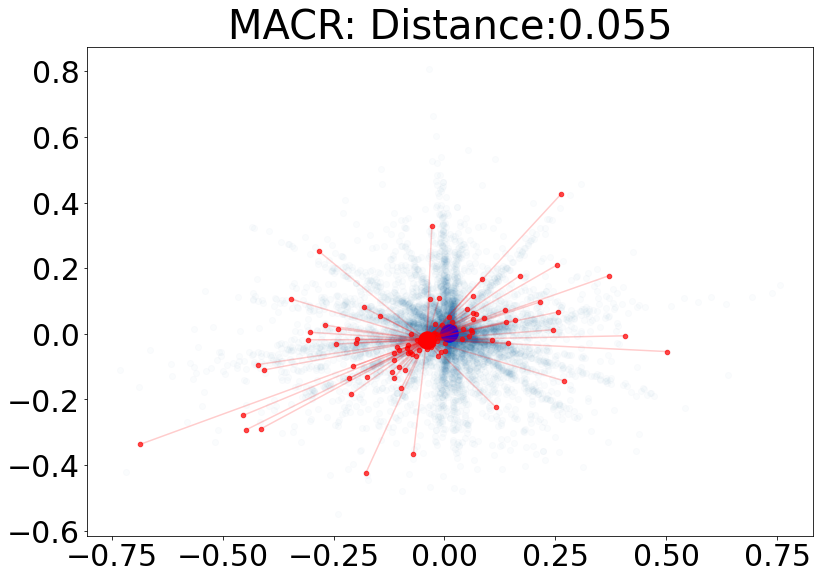

In [18]:
#MACR 
data, emb = load_all(REDRESS_data_path , MACR_path, flag=True)
u_pca, _ = PCA_on_emb(emb.detach().numpy())
cf_tid, og_tid = find_CF(data)
u_ax, u_dist = plot_counterfactuals(u_pca, og_tid, cf_tid, "MACR", annotate=False)
print("DISTANCE BETWEEN CENTROIDS: utility:{}".format(u_dist))

0.172
DISTANCE BETWEEN CENTROIDS: utility:0.17160914838314056


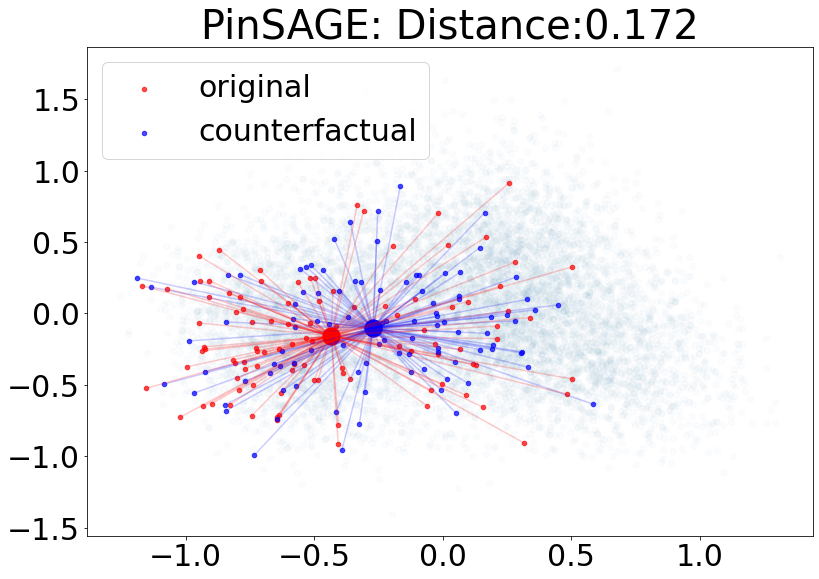

In [20]:
#PS 
data, emb = load_all(REDRESS_data_path , BOOST_utility_path, flag=True)
u_pca, _ = PCA_on_emb(emb)
cf_tid, og_tid = find_CF(data)
u_ax, u_dist = plot_counterfactuals(u_pca, og_tid, cf_tid, "PinSAGE", annotate=False, legend=True)
print("DISTANCE BETWEEN CENTROIDS: utility:{}".format(u_dist))


0.01


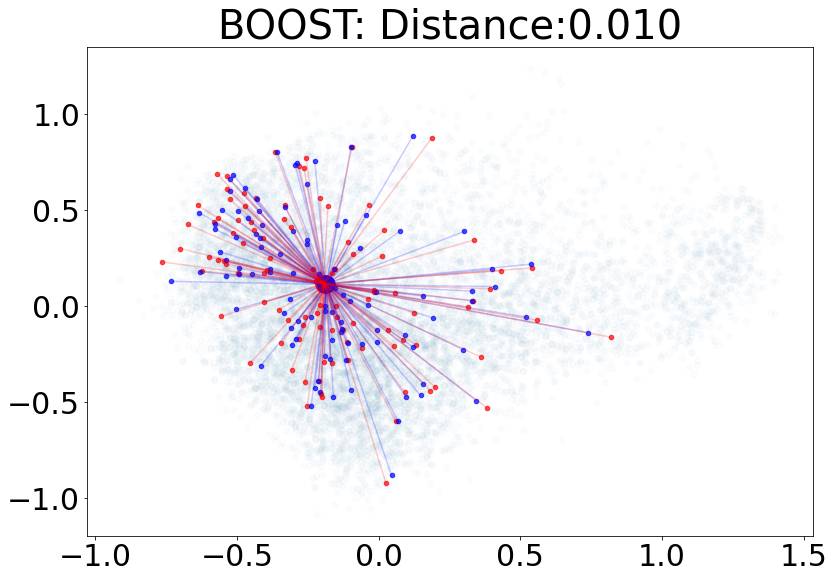

In [21]:
#BOOST 
data, emb = load_all(REDRESS_data_path , BOOST_path, flag=True)
u_pca, _ = PCA_on_emb(emb)
cf_tid, og_tid = find_CF(data)
u_ax, u_dist = plot_counterfactuals(u_pca, og_tid, cf_tid, "BOOST", annotate=False)

0.01
DISTANCE BETWEEN CENTROIDS: utility:0.0101358313113451


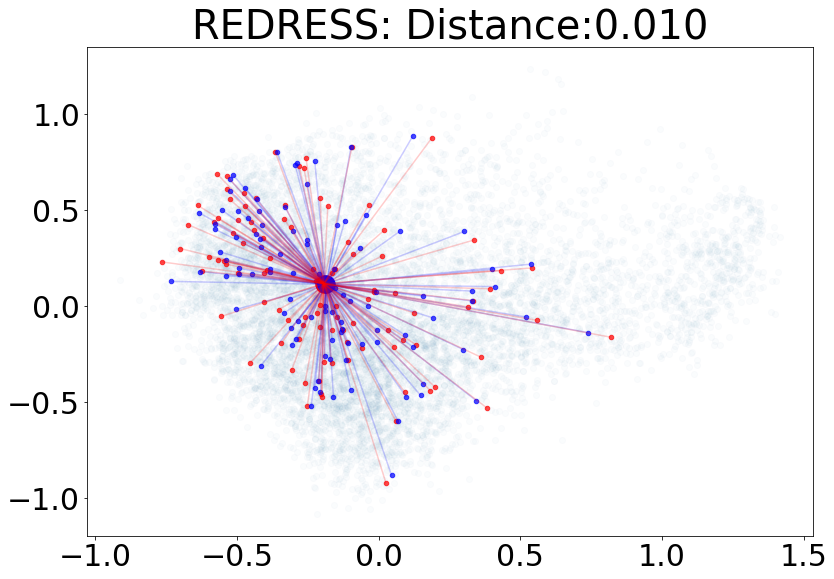

In [23]:
#REDRESS
data, emb = load_all(REDRESS_data_path , REDRESS_fair_path, flag=True)
u_pca, _ = PCA_on_emb(emb)
cf_tid, og_tid = find_CF(data)
u_ax, u_dist = plot_counterfactuals(u_pca, og_tid, cf_tid, "REDRESS", annotate=False)
print("DISTANCE BETWEEN CENTROIDS: utility:{}".format(u_dist))



0.143


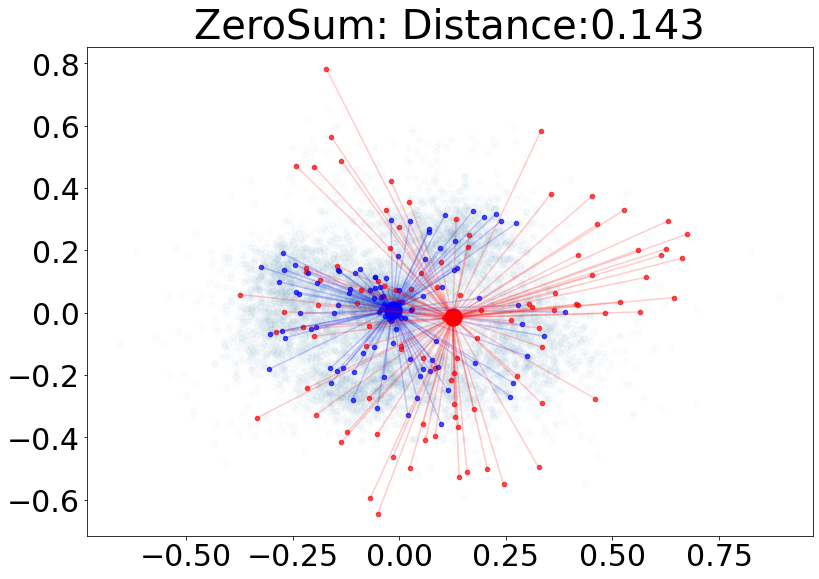

In [24]:
# NGCF 
data, emb = load_all(NGCF_data_path , NGCF_emb_path)
u_pca, _ = PCA_on_emb(emb)
cf_tid, og_tid = find_CF(data['df_track'])
u_ax, u_dist = plot_counterfactuals(u_pca, og_tid, cf_tid, "ZeroSum", annotate=False)